Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model.
We will then handle imbalance in data using various techniques and improve f1-score

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('customer_churn.csv')
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2147,2023-VQFDL,Male,0,No,No,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.00,348.8,No
3522,0969-RGKCU,Male,0,Yes,Yes,37,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.80,677.05,No
77,5590-ZSKRV,Female,0,Yes,Yes,8,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,54.65,482.25,No
95,8637-XJIVR,Female,0,No,No,12,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,78.95,927.35,Yes
5562,8023-QHAIO,Female,1,Yes,No,56,Yes,Yes,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),76.85,4275.75,No


In [30]:
df.Churn.value_counts()

,count
Churn,
No,5174
Yes,1869


In [31]:
517400/df.shape[0]

73.46301292063042

First of all, Drop customerID column as it is of no use

In [32]:
df.drop('customerID', axis = 'columns', inplace=True)

In [33]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


Quick glance at above makes me realize that TotalCharges should be float but it is an object.Let's check what's going on with this column

In [34]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

It's string let's convert into num

In [35]:
pd.to_numeric(df.TotalCharges, errors = 'coerce').isnull()

,TotalCharges
0,False
1,False
2,False
3,False
4,False
...,...
7038,False
7039,False
7040,False
7041,False


In [36]:
df[pd.to_numeric(df.TotalCharges, errors = 'coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [37]:
df.shape

(7043, 20)

In [38]:
df.iloc[488].TotalCharges

' '

In [39]:
df[df.TotalCharges != ' '].shape

(7032, 20)

Remove with spaces in TotalCharges

In [40]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [41]:
df1.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [42]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

/tmp/ipython-input-973151263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [43]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [44]:
df1[df1.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


Data Visualization

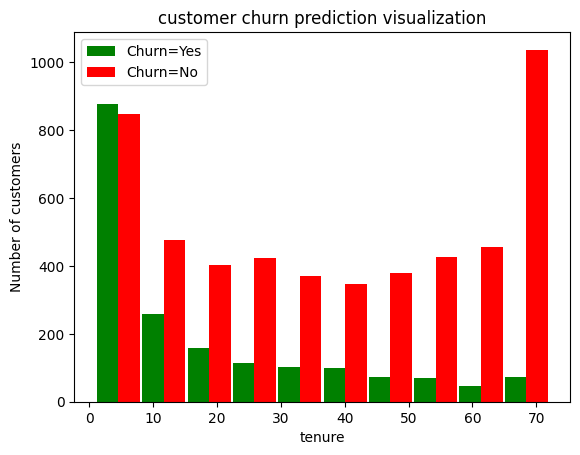

In [45]:
tenure_churn_no = df1[df1.Churn == 'No'].tenure
tenure_churn_yes = df1[df1.Churn == 'Yes'].tenure

plt.xlabel('tenure')
plt.ylabel('Number of customers')
plt.title('customer churn prediction visualization')

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn=Yes', 'Churn=No'])
plt.legend()

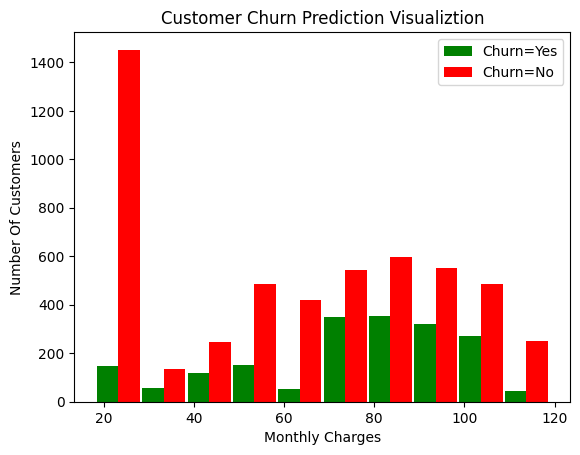

In [46]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()


Many of the columns are yes, no etc. Let's print unique values in object columns to see data values

In [47]:
def print_unique_col_values(df):
  for column in df:
    if df[column].dtypes=='object':
      print(f'{column}: {df[column].unique()}')

In [48]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


Some of the columns have no internet service or no phone service, that can be replaced with a simple No

In [49]:
df1.replace('No internet service', 'No', inplace=True)
df1.replace('No phone service', 'No', inplace=True)

/tmp/ipython-input-4245438437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service', 'No', inplace=True)
/tmp/ipython-input-4245438437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service', 'No', inplace=True)


In [50]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']



Convert Yes and No to 1 or 0

In [51]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

/tmp/ipython-input-1648037665.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
/tmp/ipython-input-1648037665.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
/tmp/ipython-input-1648037665.py:4: 

In [52]:
for col in df1:
    print(f'{col}: {df[col].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalChar

In [53]:
df1['gender'].replace({'Female':1, 'Male':0}, inplace=True)

/tmp/ipython-input-3951318906.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['gender'].replace({'Female':1, 'Male':0}, inplace=True)
/tmp/ipython-input-3951318906.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['gender'].replace({'Female':1, 'Male':0}, inplace=True)
/tmp/ipython-inp

In [54]:
df1.gender.unique()

array([1, 0])

One hot encoding for categorical columns

In [55]:
df2 = pd.get_dummies(data=df1, columns=['InternetService', 'Contract', 'PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [56]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4505,1,0,1,0,72,1,1,0,0,0,...,False,False,True,False,False,True,False,False,False,True
6571,1,0,0,0,34,1,0,1,1,0,...,True,False,False,False,True,False,False,False,False,True
5167,1,0,1,0,57,1,0,1,1,0,...,True,False,False,False,False,True,False,True,False,False
106,1,0,1,1,72,1,1,1,1,0,...,False,True,False,False,True,False,False,False,True,False
6821,1,0,0,0,18,1,1,0,0,0,...,False,True,False,True,False,False,True,False,False,False


In [57]:
df2.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
OnlineSecurity,int64
OnlineBackup,int64
DeviceProtection,int64


In [58]:
col_to_scale = ['tenure','MonthlyCharges', 'TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[col_to_scale] = scaler.fit_transform(df2[col_to_scale])

In [59]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

TrainTest Split

In [60]:
X = df2.drop('Churn', axis='columns')
y = testlabels = df2.Churn.astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [61]:
y_train.value_counts()

,count
Churn,
0.0,4130
1.0,1495


In [62]:
y.value_counts()

,count
Churn,
0.0,5163
1.0,1869


In [63]:
5163/1869

2.7624398073836276

In [64]:
y_test.value_counts()

,count
Churn,
0.0,1033
1.0,374


In [65]:
X_train.shape

(5625, 26)

In [66]:
X_test.shape

(1407, 26)

In [67]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
684,1,0,0,0,0.000000,1,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
2446,1,0,0,0,0.239437,1,1,0,1,0,...,False,True,False,True,False,False,False,True,False,False
1680,0,0,1,1,0.774648,1,1,0,0,0,...,False,False,True,False,True,False,False,False,False,True
2220,0,0,1,0,1.000000,1,0,1,1,0,...,True,False,False,False,False,True,True,False,False,False
2842,1,0,0,0,0.042254,0,0,1,0,1,...,True,False,False,True,False,False,False,False,False,True
5131,1,0,1,0,0.605634,1,1,0,0,0,...,False,True,False,True,False,False,False,False,True,False
4372,0,0,1,1,0.000000,1,0,0,0,0,...,False,False,True,True,False,False,True,False,False,False
4687,0,0,1,0,0.295775,1,0,0,0,1,...,False,True,False,True,False,False,False,True,False,False
2385,1,0,0,1,0.028169,0,0,0,1,0,...,True,False,False,True,False,False,False,False,False,True
6773,0,1,1,0,0.507042,1,1,0,0,0,...,False,True,False,True,False,False,False,False,True,False


In [68]:
len(X_train.columns)

26

In [69]:
pip install tensorflow

Build a model (ANN) in tensorflow/keras

In [70]:
from tensorflow.keras import losses

In [71]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [75]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
  model = keras.Sequential([
      keras.layers.Dense(26, input_dim = 26, activation = 'relu'),
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

  if weights == -1:
    model.fit(X_train, y_train, epochs = 100)
  else:
    model.fit(X_train, y_train, epochs = 100, class_weights = weights)

  y_pred = model.predict(X_test)
  print('Raw predictions from ANN:\n', y_pred)
  y_pred = np.round(y_pred)

  print('Classification Report:\n', classification_report(y_test, y_pred))
  return y_pred

In [76]:
y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6580 - loss: 0.5925
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7922 - loss: 0.4323
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.4198
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8057 - loss: 0.4088
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4146
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.4012
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.4060
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4174
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8041 - loss: 0.4056
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.4120
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.3902
Epoch 12/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step